# Inference of Text to Image Network

In [1]:
import torch
import lightning as L
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

from datasets import SuperresolutionMNIST
from cINN import ConditionalRealNVPImageTranslator
from autoencoder import AutoencoderSimple, Autoencoder12x12
from classifier import CNN
from utils import get_best_device

## Load pretrained models

In [2]:
autoencoder_12x12 = Autoencoder12x12()
autoencoder_12x12.load_state_dict(torch.load("./models/ae_mini.pth", map_location=get_best_device()))

autoencoder_28x28 = AutoencoderSimple()
autoencoder_28x28.load_state_dict(torch.load("./models/ae_100_new.pth", map_location=get_best_device()))

<All keys matched successfully>

In [3]:
cinn = ConditionalRealNVPImageTranslator(input_size=64, hidden_size=128, n_blocks=20, condition_size=32)
cinn.load_state_dict(torch.load('./models/cinn_superresolution.pth'))


<All keys matched successfully>

In [4]:
test_data = SuperresolutionMNIST(train=False)
test_loader = DataLoader(test_data, batch_size=100, shuffle=False)

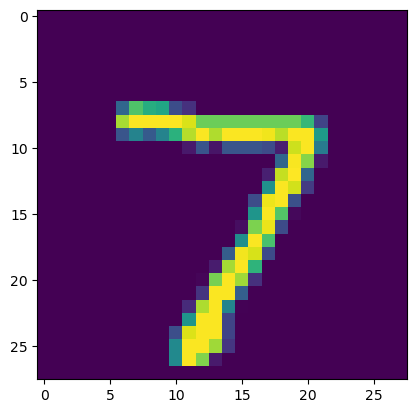

In [5]:
image, masked_image, label = test_data[0]
plt.imshow(image[0])

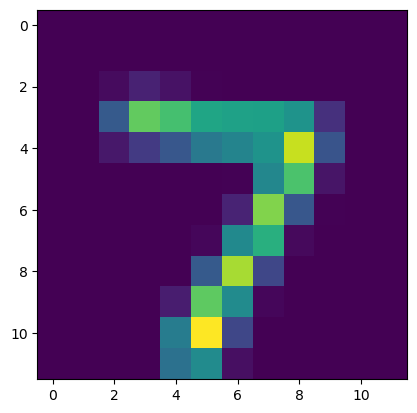

In [6]:
plt.imshow(masked_image[0])

## Sample with Condition

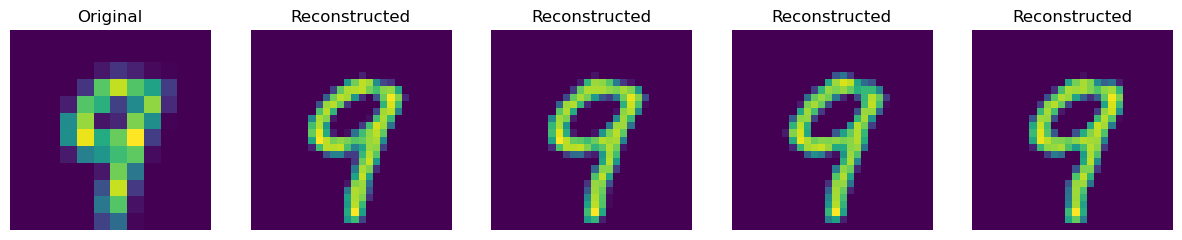

In [11]:
image, small_image, label = test_data[12]
n_samples = 4

condition = autoencoder_12x12.encoder(small_image)
cinn.eval()
samples = cinn.sample(n_samples, condition)
reconstructed_images = [autoencoder_28x28.decoder(sample).detach() for sample in samples]

fig, ax = plt.subplots(1, n_samples+1, figsize=(15, 5)) # Create a figure and a set of subplots
# Display the original image
ax[0].imshow(small_image[0,:,:])
ax[0].set_title('Original')  # Set title for the first image
ax[0].axis('off')  # Turn off axis for the first image

for i in range(0,n_samples):
# Display the reconstructed image
    ax[i+1].imshow(reconstructed_images[i][0,0,:,:])
    ax[i+1].set_title('Reconstructed')  # Set title for the second image
    ax[i+1].axis('off')  # Turn off axis for the second image


plt.show()